# Effectiveness of Prosper risk ratings, Borrower APR and EstimatedLoss
## by Anh Le

## Investigation Overview

> This analysis will verify the effectiveness of the credit scores and risk ratings that Prosper.com uses in their peer-to-peer lending service. The main focus is on the status of the loans - either bad or good, Prosper credit score, Prosper rating and FICO rating.

## Dataset Overview

> The data consists attributes of 113937 loan listings on Prosper.com. The attributes included details such as the loan amount, the loan status, the loan rating, the estimated yield, the borrower rating, the borrower income, the borrower's historical performance, percentage of the listing funded, and the number of investors invested.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
loan_df = pd.read_csv('prosperLoanData.csv')

clean_loan_df = loan_df.copy()

clean_loan_df.rename({'ProsperRating (numeric)':'ProsperRating_numeric',
               'ProsperRating (Alpha)':'ProsperRating_alpha',
                'ListingCategory (numeric)':'ListingCategory_numeric',
               'TradesNeverDelinquent (percentage)':'TradesNeverDelinquent_percentage'},axis=1,inplace=True)

#Fico credit score
fico = {"Extremely Poor": [0,299],
        "Very Poor":[300,579],
       "Fair":[580,669],
       "Good":[670,739],
       "Very Good":[740,799],
       "Exceptional":[800,850],
       "Extremely Exceptional":[851,900]}

#Taking a conservative approach to those credit score range Lower and Upper fall into 2 different categories, 
#the final fico rating will be the lower category
def find_fico_rating(lower, upper):
    fico_rating = "None"
    for x,y in fico.items():
        if (lower >= y[0] and upper <= y[1]) or (lower >= y[0] and lower <= y[1] and upper > y[1]):
            fico_rating = x
            break
    return fico_rating
        
clean_loan_df['fico_creditscore'] = clean_loan_df.apply(lambda x: find_fico_rating(x['CreditScoreRangeLower'],x['CreditScoreRangeUpper']),axis=1)        

ordinal_var_dict = {'LoanStatus': ['Cancelled','Current','FinalPaymentInProgress','Completed','Past Due (1-15 days)',
                                   'Past Due (16-30 days)','Past Due (31-60 days)','Past Due (61-90 days)',
                                  'Past Due (91-120 days)','Past Due (>120 days)','Chargedoff','Defaulted'],
                   'ProsperScore':[10,9,8,7,6,5,4,3,2,1],
                   'ProsperRating_alpha':['AA','A','B','C','D','E','HR'],
                   'fico_creditscore':['Extremely Exceptional','Exceptional','Very Good','Good','Fair','Very Poor',
                                      'Extremely Poor']}

for var in ordinal_var_dict:
    pd_ver = pd.__version__.split(".")
    if (int(pd_ver[0]) > 0) or (int(pd_ver[1]) >= 21): # v0.21 or later
        ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                    categories = ordinal_var_dict[var])
        clean_loan_df[var] = clean_loan_df[var].astype(ordered_var)
    else: # pre-v0.21
        clean_loan_df[var] = clean_loan_df[var].astype('category', ordered = True,
                                             categories = ordinal_var_dict[var])
        

subset_loan_df = clean_loan_df[clean_loan_df.LoanStatus.isin(['Defaulted','Chargedoff','Completed'])].copy()

subset_loan_df['is_badloan'] = subset_loan_df.apply(lambda x: 'No' if x.LoanStatus == 'Completed' else 'Yes',axis=1)

ordinal_var_dict = {'is_badloan': ['No','Yes']}

for var in ordinal_var_dict:
    pd_ver = pd.__version__.split(".")
    if (int(pd_ver[0]) > 0) or (int(pd_ver[1]) >= 21): # v0.21 or later
        ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                    categories = ordinal_var_dict[var])
        subset_loan_df[var] = subset_loan_df[var].astype(ordered_var)
    else: # pre-v0.21
        subset_loan_df[var] = subset_loan_df[var].astype('category', ordered = True,
                                             categories = ordinal_var_dict[var])
    

> Note that the above cells have been set as "Skip"-type slides. That means
that when the notebook is rendered as http slides, those cells won't show up.

## Distribution of different Loan Status

> The % of Chargedoff and Defaulted Loans are relatively high, in total, about 15% of the total number of loans, and about 50% of the number of Completed Loans. Hence, this analysis will verify the efficiency of the credit scores and risk ratings that Prosper.com uses. 

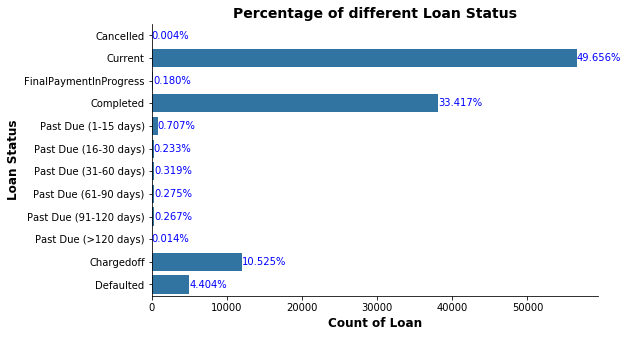

In [3]:
#if not provided, defaults to rcParams["figure.figsize"] = [6.4, 4.8].

plt.figure(figsize=(8,5))

base_color = sb.color_palette()[0]
sb.countplot(data=clean_loan_df,y='LoanStatus',color=base_color);

# add annotations
n_points = clean_loan_df.shape[0]
cat_counts = clean_loan_df.LoanStatus.value_counts()
locs, labels = plt.yticks() # get the current tick locations and labels

# loop through each pair of locations and labels
for loc, label in zip(locs, labels):

    # get the text property for the label to get the correct count
    count = cat_counts[label.get_text()]
    pct_string = '{:0.3f}%'.format(100*count/n_points)

    # print the annotation just below the top of the bar
    plt.text(count+5, loc, pct_string, ha = 'left',va='center', color = 'b')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.title('Percentage of different Loan Status',fontsize=14,fontweight='bold')
plt.xlabel('Count of Loan',fontsize=12,fontweight='bold')
plt.ylabel('Loan Status',fontsize=12,fontweight='bold');


## Loan Status and ProsperRating_alpha
> Loan Status of concluded Loan is either good or bad. Prosper has good success rate across all its loan Ratings. The success Rate of each loan rating = the % of good loans (i.e. completed loans) / the total number of (good & bad) loans in the rating. The lowest success rate is 61.8% and is for loans with HR rating. This suggests that Prosper Rating and the company working model are effective.

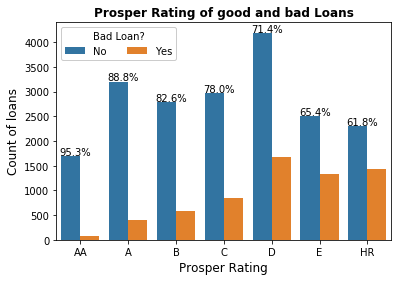

In [5]:

ax = sb.countplot(data = subset_loan_df, x = 'ProsperRating_alpha', hue = 'is_badloan')
ax.legend(loc = 'best', ncol = 2, framealpha = 1, title = 'Bad Loan?');
plt.title('Prosper Rating of good and bad Loans',fontsize=12,fontweight='bold')
plt.xlabel('Prosper Rating',fontsize=12)
plt.ylabel('Count of loans',fontsize=12);

# add annotations
cat_counts = subset_loan_df.ProsperRating_alpha.value_counts()
locs, labels = plt.xticks() # get the current tick locations and labels

# loop through each pair of locations and labels
for loc, label in zip(locs, labels):
    success_count = subset_loan_df[(subset_loan_df.ProsperRating_alpha == label.get_text()) &
                                   (subset_loan_df.is_badloan == 'No')].is_badloan.count()
    
    # get the text property for the label of success rate
    pct_string= '{:0.1f}%'.format(100*(success_count/cat_counts.get(label.get_text())))
   
    # print the annotation just below the top of the bar
    plt.text(loc-0.1, success_count+20, pct_string, ha = 'center', color = 'black')




## The Loan Status and  FICO credit score
> Prosper.com has bad success rate for the loan with "Very Poor" and "Extremely Poor" FICO score. The success Rate of each FICO Score = the % of good loans (i.e. completed loans) / the total number of (good & bad) loans in the FICO Score rating. The lowest success rate is 29.3% and is for loans with the "Extremely Poor" Score, follwed by 43.1% for loans with "Very Poor" score. This suggests that there are rooms for improvement for Prosper.com in these 2 FICO ratings, and that investors should look for other risk ratings as well if they want to lend money to borrowers of "Very Poor" and "Extremly Poor" ratings.

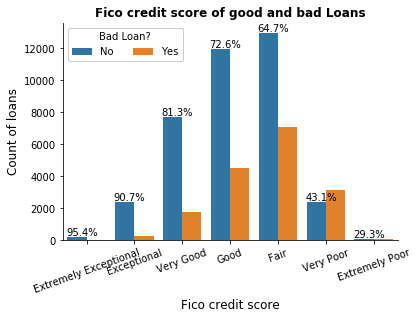

In [6]:

ax = sb.countplot(data = subset_loan_df, x = 'fico_creditscore', hue = 'is_badloan')
ax.legend(loc = 'best', ncol = 2, framealpha = 1, title = 'Bad Loan?');
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.title('Fico credit score of good and bad Loans',fontsize=12,fontweight='bold')
plt.xticks(rotation=20)
plt.xlabel('Fico credit score',fontsize=12)
plt.ylabel('Count of loans',fontsize=12);


# add annotations
cat_counts = subset_loan_df.fico_creditscore.value_counts()
locs, labels = plt.xticks() # get the current tick locations and labels

# loop through each pair of locations and labels
for loc, label in zip(locs, labels):
    success_count = subset_loan_df[(subset_loan_df.fico_creditscore == label.get_text()) &
                                   (subset_loan_df.is_badloan == 'No')].is_badloan.count()
   
    #get the text property for the label of success rate
    pct_string= '{:0.1f}%'.format(100*(success_count/cat_counts.get(label.get_text())))
   
    # print the annotation just below the top of the bar
    plt.text(loc-0.1, success_count+100, pct_string, ha = 'center', color = 'black')




##  Loan Status  and  Estimated Loss
> Most of the bad loans have the estimated principle loss higher than about 7%. The median of the estimated principle loss of the bad loan is higher than that of the good loans. This suggests that Prosper's estimation is good and helpful to investors.

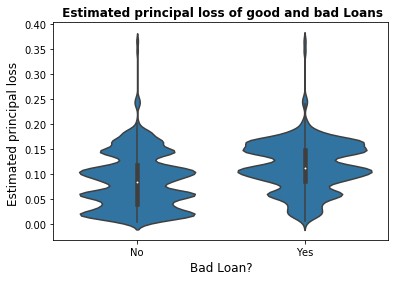

In [8]:
base_color = sb.color_palette()[0]
sb.violinplot(data = subset_loan_df, x = 'is_badloan', y = 'EstimatedLoss', color = base_color);
plt.title(' Estimated principal loss of good and bad Loans',fontsize=12,fontweight='bold')
plt.xlabel('Bad Loan?',fontsize=12)
plt.ylabel('Estimated principal loss ',fontsize=12);

## Borrower APR vs Prosper Rating vs Loan Status
> Borrower APR of the bad loans are higher than that of the Good Loans, except for those loan listings of high risk with Prosper Rating of D, E and HR. This suggests that Prosper.com is doing a good job in setting the Borrower APR.


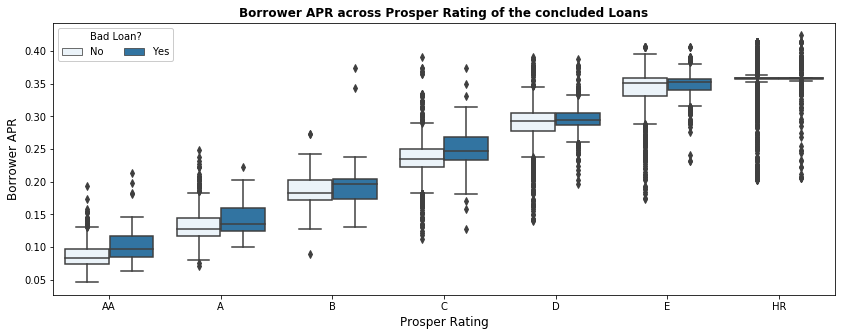

In [9]:
plt.figure(figsize=(14, 5))
base_color = sb.color_palette()[0]
ax = sb.boxplot(data=subset_loan_df,x='ProsperRating_alpha',y='BorrowerAPR',
                   hue='is_badloan',color=base_color)
ax.legend(loc = 'best', ncol = 2, framealpha = 1, title = 'Bad Loan?');
plt.title('Borrower APR across Prosper Rating of the concluded Loans',fontsize=12,fontweight='bold')
plt.xlabel('Prosper Rating',fontsize=12)
plt.ylabel('Borrower APR',fontsize=12);
#inner='quartile'

## LP_NetPrincipalLoss vs LoanOriginalAmount vs ProsperRating of bad loans
>- For high risk ratings - D, E, HR, the bad Loans have low Amounts, they are <= \\$15K; and the Net principle loss can  be the full principle or almost 0. 
>- For the good risk rating - AA and A, the bad loans spread from low to  very high amount (\\$25K). The net principle loss are also high, most of them are close to the principle, only few loss are low
>- For the middle range of risk rating - B and C, the bad loans can be of high amount, but less number of bad loans having amount > \\$15K compared to those of the good ratings.  The principle loss of the large loans are close to the full principle.


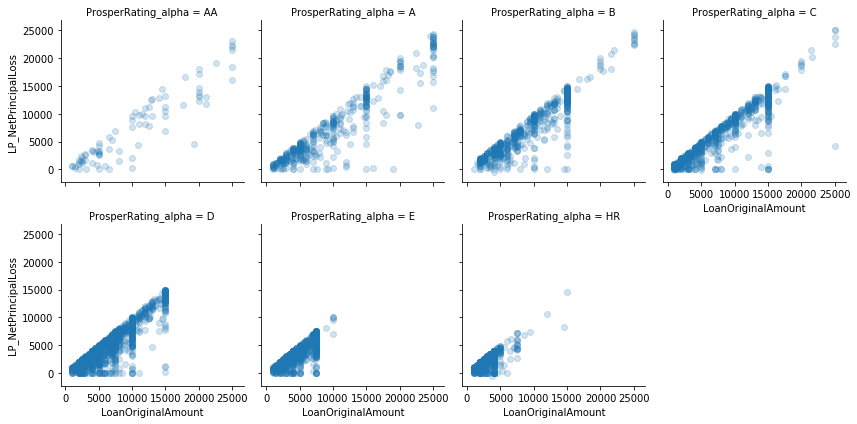

In [10]:
g = sb.FacetGrid(data=subset_loan_df[subset_loan_df.is_badloan=='Yes'],
                 col='ProsperRating_alpha',col_wrap=4,margin_titles=True);
g.map(plt.scatter,'LoanOriginalAmount','LP_NetPrincipalLoss',alpha = 1/5);



## Conclusion
> Prosper.com is effective in rating risk of the loan, setting Borrower APR and estimation of principle loss

> There are still rooms for improvement as the % of chargedoff and defaulted loans are relatively high, and the Net principle loss is considerable.

>- If I was to invest in any loan on Prosper.com, I'd choose the middle Prosper risk rating B and C, as they have high success rate of 82% & 78% respectively, and come with good Interest rate

> Once you're ready to finish your presentation, check your output by using
nbconvert to export the notebook and set up a server for the slides. From the
terminal or command line, use the following expression:
> > `jupyter nbconvert <file_name>.ipynb --to slides --post serve --template output_toggle`

> This should open a tab in your web browser where you can scroll through your
presentation. Sub-slides can be accessed by pressing 'down' when viewing its parent
slide. Make sure you remove all of the quote-formatted guide notes like this one
before you finish your presentation!